In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image as Image

batch_size = 4

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [11]:
## Import Fashion MNISt
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
# testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

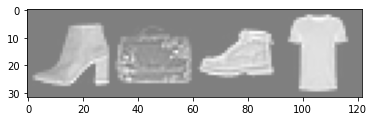

In [12]:
## display images from trainloader
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# display a 3 x 3 grid of images from trainloader
def show_grid():
    dataiter = iter(trainloader)
    images, labels = dataiter.next()
    imshow(torchvision.utils.make_grid(images))

def de_normalize(img):
    img = img / 2 + 0.5 
    return img

#use matplotlib to display generated images
def show_generated_images(generator):
    random_noise = torch.randn((16, 28, 28)).to(device)
    generated_images = de_normalize(generator(random_noise)).cpu()

    fig, ax = plt.subplots(4, 4, figsize=(8, 4))
    for i in range(4):
        for j in range(4):
            ax[i, j].imshow(generated_images[i*4 + j].detach().numpy().reshape(28, 28), cmap='gray')
            ax[i, j].axis('off')
    fig.set_size_inches(5, 5)
    plt.show()

transform = transforms.Compose([transforms.Normalize((0.5,), (0.5,))])

show_grid()

In [14]:
#Generative model G
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 25)
        self.fc3 = nn.Linear(256, 28*28)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x
    
# Discriminative model D
class Discriminator(nn.Module):
    #1 for real, 0 for generated
    """Output represents probability of image being real(as opposed to fake)."""
    def __init__(self):
        super(Discriminator, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.tanh(self.fc3(x))
        return x
    
generator = Generator().to(device)
discriminator = Discriminator().to(device)
images = next(iter(trainloader))[0].to(device)
print(generator(images).shape, discriminator(images).shape)
print(sum(p.numel() for p in generator.parameters() if p.requires_grad), sum(p.numel() for p in discriminator.parameters() if p.requires_grad)  )
discriminator(generator(images)).shape

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
#generator total parameters
 



In [ ]:
torch.randn((batch_size, 28, 28)).shape

In [ ]:
epochs = 10
learning_rate = 3e-3

loss_fn = nn.BCELoss()

d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate)
g_optimizer = optim.Adam(generator.parameters(), lr=learning_rate)

for epoch in range(epochs):
    for i , (images, _) in enumerate(trainloader):
        images = transform(images).to(device)

        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        ###### Train Discriminator ######
        #train discriminator on real images
        real_loss = loss_fn(discriminator(images), real_labels)

        #train discriminator on fake images
        random_noise = torch.randn((batch_size, 28, 28)).to(device) 
        fake_loss = loss_fn(discriminator(generator(random_noise)), fake_labels)
        
        discriminator_loss = (real_loss + fake_loss) / 2
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        discriminator_loss.backward()
        d_optimizer.step()
        ###### Train Generator ######

        random_noise = torch.randn((batch_size, 28, 28)).to(device)
        fake_images = generator(random_noise)

        generator_loss = loss_fn(discriminator(fake_images), real_labels)
        
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        generator_loss.backward()
        g_optimizer.step()

        if i % 100 == 0:
            print(f"Epoch {epoch} Batch {i} Generator loss {generator_loss:.4f} Discriminator loss {discriminator_loss:.4f}")
            show_generated_images(generator)
            


In [ ]:
plt